In [1]:
import scifAI
import matplotlib.pyplot as plt
from scifAI.ml import features
from scifAI.ml import AutoFeatureSelection
from scifAI.ml import FeatureExtractor 
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import  FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
from scifAI.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


In [2]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets']

def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [3]:
selected_subset = pd.read_csv("ali_annotation.csv")
# selected_subset = pd.read_csv("nikos_annotation.csv")
# selected_subset = pd.read_csv("ke_annotation.csv")
# selected_subset = pd.read_csv("tijana_annotation.csv")


selected_subset.head()

,object_number,label
0,5513,T_cell
1,8190,T_cell
2,12834,T_cell
3,30937,T_cell_with_B_cell_fragments
4,31356,B_cell


In [4]:

label_map = {'Single B-LCL':'B_cell',  
             'single B-LCL cells':'B_cell',
             'T cell w/o signaling':'T_cell', 
             'T cell w/ signaling':'T_cell_with_signaling',
             'T cell w/ small B-LCL':'T_cell_with_B_cell_fragments',
             'T cell w/ small B-LCL ':'T_cell_with_B_cell_fragments',
             'B-LCL & T cell in one layer':'B_T_cell_in_one_layer',
             'Synapse w/o signaling':'Synapses_without_signaling', 
             'Synapse w/ signaling':'Synapses_with_signaling',
             'No cell-cell interaction':'No_cell_cell_interaction', 
             'Multi-synapse':'Multiplets',
             'Multi-Synapse':'Multiplets',
             'Single B-LCL':'B_cell',  
             'single B-LCL cells':'B_cell',
             'single B-LCL':'B_cell',
             'T cell w/o signaling':'T_cell',  
             'T cell w/o signalling':'T_cell', 
             'T cell w/ signaling':'T_cell_with_signaling',
             'T cell w/ signalling':'T_cell_with_signaling',
             'T cell with signaling':'T_cell_with_signaling',
             'T cell with small B-LCL':'T_cell_with_B_cell_fragments',
             'T cell w/ small B-LCL':'T_cell_with_B_cell_fragments',
             'T cell w/ small B-LCL ':'T_cell_with_B_cell_fragments',
             'B-LCL & T cell in one layer':'B_T_cell_in_one_layer',
             'Synapse w/o signaling':'Synapses_without_signaling', 
             'synapse w/o signalling':'Synapses_without_signaling', 
             'synape w/o signalling':'Synapses_without_signaling',  
             'synpase w/o signalling':'Synapses_without_signaling',  
             'synpase w/o signalling':'Synapses_without_signaling',  
             'Synapse w/signalling':'Synapses_with_signaling', 
             'synapse w/ signalling':'Synapses_with_signaling', 
             'Synapse w/ signalling':'Synapses_with_signaling', 
             'Synapse w/ signaling':'Synapses_with_signaling',
             'synpase w/ signalling':'Synapses_with_signaling',
             'synapse w/signalling':'Synapses_with_signaling',
             'Synapse with signaling':'Synapses_with_signaling',
             'No cell-cell interaction':'No_cell_cell_interaction', 
             'no cell-cell interaction':'No_cell_cell_interaction', 
             'Multi-synapse':'Multiplets',
             'Multiplets':'Multiplets',
             'Multi-Synapse':'Multiplets',
             'multi-synapse':'Multiplets',
            }

if "class" in selected_subset.columns:
    selected_subset["label"] = selected_subset["class"].replace(label_map)
elif "Classification" in selected_subset.columns:
    selected_subset["label"] = selected_subset["Classification"].replace(label_map)
    selected_subset["object_number"] = selected_subset["Objet number"]
elif "label" in selected_subset.columns:
    selected_subset["label"] = selected_subset["label"].replace(label_map)

selected_subset = selected_subset.sort_values("object_number").reset_index(drop=True)

In [5]:
selected_subset.label.unique()

array(['T_cell', 'T_cell_with_B_cell_fragments', 'B_cell',
       'Synapses_with_signaling', 'No_cell_cell_interaction',
       'T_cell_with_signaling', 'Multiplets',
       'Synapses_without_signaling', 'B_T_cell_in_one_layer'],
      dtype=object)

In [6]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")

indx = metadata.donor == "Donor_1"
indx = indx & ( metadata.experiment == "Experiment_3")
indx = indx & metadata.set.isin(["test"])
indx = indx & metadata.object_number.isin(selected_subset.object_number.tolist())

metadata = metadata.loc[indx,:].sort_values("object_number").reset_index(drop=True)
metadata.head()

,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_3,Donor_1,-SEA,5513,test,T_cell,T_cell,0.049252,Experiment_3 Donor_1,False,1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_3,Donor_1,-SEA,8190,test,T_cell,T_cell,0.002250,Experiment_3 Donor_1,False,1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_3,Donor_1,-SEA,12834,test,T_cell,T_cell,0.038361,Experiment_3 Donor_1,False,1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_3,Donor_1,-SEA,30937,test,T_cell_with_B_cell_fragments,T_cell_with_B_cell_fragments,0.613960,Experiment_3 Donor_1,False,1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_3,Donor_1,-SEA,31356,test,B_cell,B_cell,0.032091,Experiment_3 Donor_1,False,2


                              precision    recall  f1-score   support

                      B_cell       1.00      1.00      1.00        12
                      T_cell       0.75      1.00      0.86        12
       T_cell_with_signaling       0.88      0.64      0.74        11
T_cell_with_B_cell_fragments       0.74      0.85      0.79        20
       B_T_cell_in_one_layer       0.33      0.12      0.18         8
  Synapses_without_signaling       0.75      0.60      0.67         5
     Synapses_with_signaling       0.83      0.94      0.88        16
    No_cell_cell_interaction       1.00      0.86      0.92         7
                  Multiplets       0.90      1.00      0.95         9

                    accuracy                           0.82       100
                   macro avg       0.80      0.78      0.78       100
                weighted avg       0.80      0.82      0.80       100

------------------------------------------------------------
matthews correlation coeff

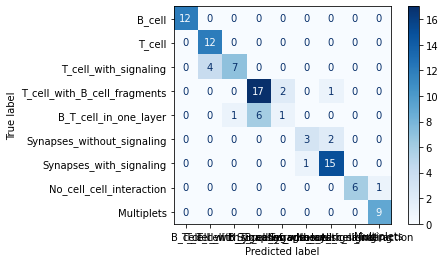

------------------------------------------------------------


In [7]:
classification_complete_report(metadata.label, selected_subset.label, labels = set_of_interesting_classes)

## second round

In [8]:
import scifAI
import matplotlib.pyplot as plt
from scifAI.ml import features
from scifAI.ml import AutoFeatureSelection
from scifAI.ml import FeatureExtractor 
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import  FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
from scifAI.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


In [9]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets']

def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [10]:

label_map = {'Single B-LCL':'B_cell',  
             'single B-LCL cells':'B_cell',
             'single B-LCL':'B_cell',
             'T cell w/o signaling':'T_cell',  
             'T cell w/o signalling':'T_cell', 
             'T cell w/ signaling':'T_cell_with_signaling',
             'T cell w/ signalling':'T_cell_with_signaling',
             'T cell with signaling':'T_cell_with_signaling',
             'T cell with small B-LCL':'T_cell_with_B_cell_fragments',
             'T cell w/ small B-LCL':'T_cell_with_B_cell_fragments',
             'T cell w/ small B-LCL ':'T_cell_with_B_cell_fragments',
             'B-LCL & T cell in one layer':'B_T_cell_in_one_layer',
             'Synapse w/o signaling':'Synapses_without_signaling', 
             'synapse w/o signalling':'Synapses_without_signaling', 
             'synape w/o signalling':'Synapses_without_signaling',  
             'synpase w/o signalling':'Synapses_without_signaling',  
             'synpase w/o signalling':'Synapses_without_signaling',  
             'Synapse w/signalling':'Synapses_with_signaling', 
             'synapse w/ signalling':'Synapses_with_signaling', 
             'Synapse w/ signalling':'Synapses_with_signaling', 
             'Synapse w/ signaling':'Synapses_with_signaling',
             'synpase w/ signalling':'Synapses_with_signaling',
             'synapse w/signalling':'Synapses_with_signaling',
             'Synapse with signaling':'Synapses_with_signaling',
             'No cell-cell interaction':'No_cell_cell_interaction', 
             'no cell-cell interaction':'No_cell_cell_interaction', 
             'Multi-synapse':'Multiplets',
             'Multiplets':'Multiplets',
             'Multi-Synapse':'Multiplets',
             'multi-synapse':'Multiplets',
            }

In [11]:
selected_subset = pd.read_csv("inter-rater-second-round.csv")


selected_subset.head()
for p in ["KE","NK","AB","EG", "TN"]:
    for k in selected_subset[p].unique():
        if k not in label_map:
            print(p, k)
            
    selected_subset[p] = selected_subset[p].replace(label_map)

In [12]:
selected_subset.sample(200, random_state=0)

,object_number,original_label,KE,NK,AB,EG,TN
96,41061,No_cell_cell_interaction,No_cell_cell_interaction,No_cell_cell_interaction,No_cell_cell_interaction,No_cell_cell_interaction,No_cell_cell_interaction
203,248958,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling
169,231800,T_cell,T_cell,T_cell,T_cell,T_cell,T_cell
136,221392,T_cell_with_signaling,T_cell_with_signaling,T_cell_with_signaling,T_cell_with_signaling,T_cell_with_signaling,T_cell_with_signaling
182,235990,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling
...,...,...,...,...,...,...,...
115,220214,T_cell,T_cell,T_cell,T_cell,T_cell,T_cell
148,223805,Synapses_without_signaling,Synapses_without_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_without_signaling,Synapses_with_signaling
216,261021,Synapses_without_signaling,Synapses_without_signaling,Synapses_without_signaling,Synapses_without_signaling,Synapses_without_signaling,Synapses_without_signaling
72,20001,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,Synapses_with_signaling,B_cell,Synapses_with_signaling


KE
                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.80      0.62      0.70        13
                      B_cell       1.00      1.00      1.00        22
                  Multiplets       0.92      1.00      0.96        23
    No_cell_cell_interaction       1.00      1.00      1.00        38
     Synapses_with_signaling       0.95      0.93      0.94        44
  Synapses_without_signaling       0.83      1.00      0.91        15
                      T_cell       1.00      1.00      1.00        23
T_cell_with_B_cell_fragments       0.96      0.92      0.94        25
       T_cell_with_signaling       1.00      1.00      1.00        21

                    accuracy                           0.96       224
                   macro avg       0.94      0.94      0.94       224
                weighted avg       0.96      0.96      0.95       224

------------------------------------------------------------
matthews correlation co

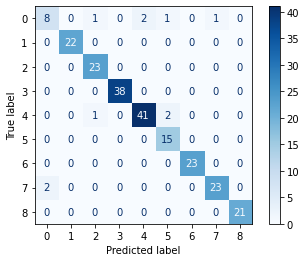

------------------------------------------------------------


In [13]:
print("KE")

classification_complete_report(selected_subset["original_label"], selected_subset["KE"])

AB
                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.80      0.31      0.44        13
                      B_cell       1.00      1.00      1.00        22
                  Multiplets       0.96      0.96      0.96        23
    No_cell_cell_interaction       1.00      0.55      0.71        38
     Synapses_with_signaling       0.64      0.98      0.77        44
  Synapses_without_signaling       0.59      0.87      0.70        15
                      T_cell       0.95      0.91      0.93        23
T_cell_with_B_cell_fragments       0.81      0.52      0.63        25
       T_cell_with_signaling       0.81      1.00      0.89        21

                    accuracy                           0.80       224
                   macro avg       0.84      0.79      0.78       224
                weighted avg       0.84      0.80      0.79       224

------------------------------------------------------------
matthews correlation co

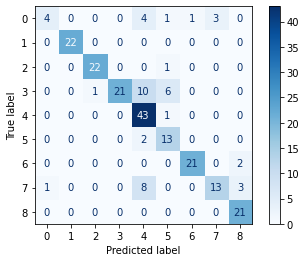

------------------------------------------------------------


In [14]:
print("AB")

classification_complete_report(selected_subset["original_label"], selected_subset["AB"])

NK
                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.62      0.38      0.48        13
                      B_cell       0.92      1.00      0.96        22
                  Multiplets       0.69      0.96      0.80        23
    No_cell_cell_interaction       0.92      0.92      0.92        38
     Synapses_with_signaling       0.65      0.82      0.73        44
  Synapses_without_signaling       0.61      0.73      0.67        15
                      T_cell       0.96      1.00      0.98        23
T_cell_with_B_cell_fragments       1.00      0.12      0.21        25
       T_cell_with_signaling       0.91      0.95      0.93        21

                    accuracy                           0.79       224
                   macro avg       0.81      0.77      0.74       224
                weighted avg       0.82      0.79      0.76       224

------------------------------------------------------------
matthews correlation co

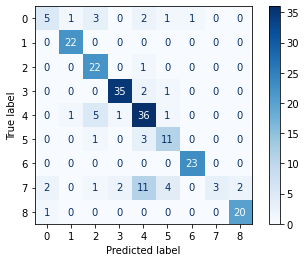

------------------------------------------------------------


In [15]:
print("NK")

classification_complete_report(selected_subset["original_label"], selected_subset["NK"])

TN
                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.75      0.69      0.72        13
                      B_cell       1.00      1.00      1.00        22
                  Multiplets       0.77      1.00      0.87        23
    No_cell_cell_interaction       0.95      0.92      0.93        38
     Synapses_with_signaling       0.75      0.98      0.85        44
  Synapses_without_signaling       1.00      0.47      0.64        15
                      T_cell       1.00      0.78      0.88        23
T_cell_with_B_cell_fragments       1.00      0.60      0.75        25
       T_cell_with_signaling       0.81      1.00      0.89        21

                    accuracy                           0.86       224
                   macro avg       0.89      0.83      0.84       224
                weighted avg       0.89      0.86      0.85       224

------------------------------------------------------------
matthews correlation co

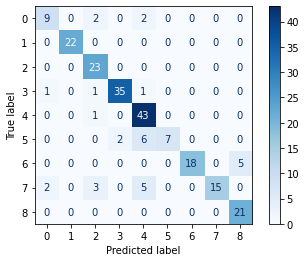

------------------------------------------------------------


In [16]:
print("TN")

classification_complete_report(selected_subset["original_label"], selected_subset["TN"])

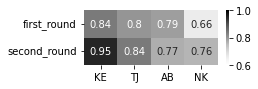

In [18]:
heatmap_data = {
    "first_round" : [0.84, 0.80, 0.79, 0.66],
    "second_round" : [0.95, 0.84, 0.77, 0.76],
}

heatmap_data = pd.DataFrame(heatmap_data)
heatmap_data = heatmap_data.T
heatmap_data.columns = ["KE", "TJ", "AB", "NK"]

fig, ax = plt.subplots(figsize=(3,1))

ax = sns.heatmap(heatmap_data, cmap="Greys", vmin=0.6, vmax=1.0, annot=True)

plt.savefig("rater kappa.png", bbox_inches="tight")
plt.savefig("rater kappa.svg", bbox_inches="tight")